last edited by Claire Valva on September 21, 2018

# ifft of 40.5N data

##### to do/questions: should I go back and find the monthly means of the transforms as well?, doesn't seem necessary but should give more thought

In [5]:
#import packages
import numpy as np
from scipy.signal import get_window, csd
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import matplotlib.cm as cm
from math import pi
import matplotlib.ticker as tck
import datetime
from sympy import solve, Poly, Eq, Function, exp, re, im
from PyEMD import EMD
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.optimize import fsolve
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex

In [6]:
from functions_forspectralanalysis import *

## import and label files

In [7]:
#get raw fft
import pickle
    
file_Name = "raw_fft_results_sept18"
file_pickle = open(file_Name, "rb")
raw_fft_results = pickle.load(file_pickle)

In [8]:
#unpack these
ffts_time, ffts_zone = raw_fft_results
fft_grouped_wind, names = ffts_time
season_zonal_fft_avg = ffts_zone[0][1]
total_zonal_fft_avg = ffts_zone[1][1]

In [9]:
#get list of years and seasons to perform transform/detrend on
years = range(1979,2017)
seasons = ["winter", "spring", "summer", "fall"]

In [10]:
def get_ind(match, sublist):
    #function gets indices of the sublist that equal the match term
    toreturn = [j for j in range(len(sublist)) if sublist[j] == match]
    return toreturn

#get list of year/seasons/longitudes
time_fft_seasons = [sublist[0] for sublist in names]
time_fft_year = [sublist[1] for sublist in names]
time_fft_lon = [sublist[2] for sublist in names]

#get lists of indicies
lon_index_time = [get_ind(k, time_fft_lon) for k in lon_list]
season_index_time = [get_ind(match, time_fft_seasons) for match in seasons]
year_index_time = [get_ind(year, time_fft_year) for year in year_list]

def condition_func_wint(i):
    results = i in winter_indices 
    return(results)

#want to mean over time, also make sure not to use the first summer
winter_indices, spring_indices, summer_indices, fall_indices = season_index_time

#get matches for winter and longitude, where year != 1979
winter_lon_indices = [[i for i in lon_index_time[j] if condition_func_wint(i)] 
                      for j in range(len(lon_list))]

spring_lon_indices = [[i for i in lon_index_time[j] if i in spring_indices]
                     for j in range(len(lon_list))]

summer_lon_indices = [[i for i in lon_index_time[j] if i in summer_indices]
                     for j in range(len(lon_list))]

fall_lon_indices = [[i for i in lon_index_time[j] if i in fall_indices]
                     for j in range(len(lon_list))]

def get_avglist(indices, valuelist, ax = 0):
    #from indices and the value list, returns the list with the same indices
    toavg = [valuelist[i] for i in indices]
    averaged = np.average(toavg, axis = ax)
    return averaged

#now get the averages of each spectrum for the lists
winter_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in winter_lon_indices]
spring_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in spring_lon_indices]
fall_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in fall_lon_indices]
summer_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in summer_lon_indices]

#put them all into  a single list
time_ffts_list_avg = [winter_ffts, spring_ffts, summer_ffts, fall_ffts]

## get ifft

In [11]:
#perform ifft on time data
time_allsea_ifft_list = [[ifft(sublist) for sublist in time_ffts_list_avg[j]] 
                         for j in range(4)]
nolon_time_allsea_ifft = [ifft(sublist) for sublist in np.average(time_ffts_list_avg, axis = 1)]


#perform ifft on zonal data
zonal_allsea_ifft_list = [ifft(sublist) for sublist in season_zonal_fft_avg]

## plot ifft

## geopotential averages at each longitude

#### average ifft, zonal

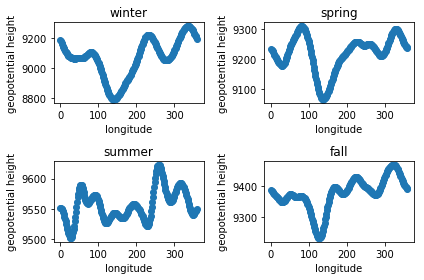

In [14]:
display(Markdown("#### average ifft, zonal"))

plt.clf()

for i in range(4):
    plt.subplot(2,2,1 + i)
    plt.scatter(lon_list, np.abs(zonal_allsea_ifft_list[i]))
    plt.title(seasons[i])
    plt.ylabel("geopotential height")
    plt.xlabel("longitude")

plt.tight_layout()
plt.show()

In [15]:
#flatten lists for plotting
flat_nolon_time_allsea_ifft = [[leaf for tree in time_allsea_ifft_list[i] for leaf in tree] for i in range(4)]
#get proxy x coords
rep_list = [[list(range(372)) for j in range(240)] for i in range(4)]
flat_rep_list = [[leaf for tree in rep_list[season] for leaf in tree] for season in range(4)]

#### average ifft, time

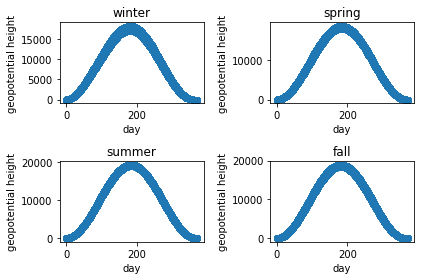

In [16]:
display(Markdown("#### average ifft, time"))

plt.clf()

for i in range(4):
    plt.subplot(2,2,1 + i)
    plt.scatter(flat_rep_list[i], np.abs(flat_nolon_time_allsea_ifft[i]))
    plt.title(seasons[i])
    plt.ylabel("geopotential height")
    plt.xlabel("day")

plt.tight_layout()
plt.show()

In [17]:
#get the mean for each season at each longitude?
avg_at_lon = [[np.mean(time_allsea_ifft_list[season][i]) 
               for i in range(240)] for season in range(4)]

#### average ifft, time, meaned at lon pts

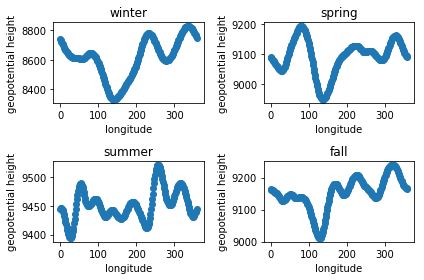

In [18]:
display(Markdown("#### average ifft, time, meaned at lon pts"))

plt.clf()

for i in range(4):
    plt.subplot(2,2,1 + i)
    plt.scatter(lon_list, np.abs(avg_at_lon[i]))
    plt.title(seasons[i])
    plt.ylabel("geopotential height")
    plt.xlabel("longitude")

plt.tight_layout()
plt.show()

#### how similar are these? 

#### average ifft, time and zonal compared

<Figure size 432x288 with 0 Axes>

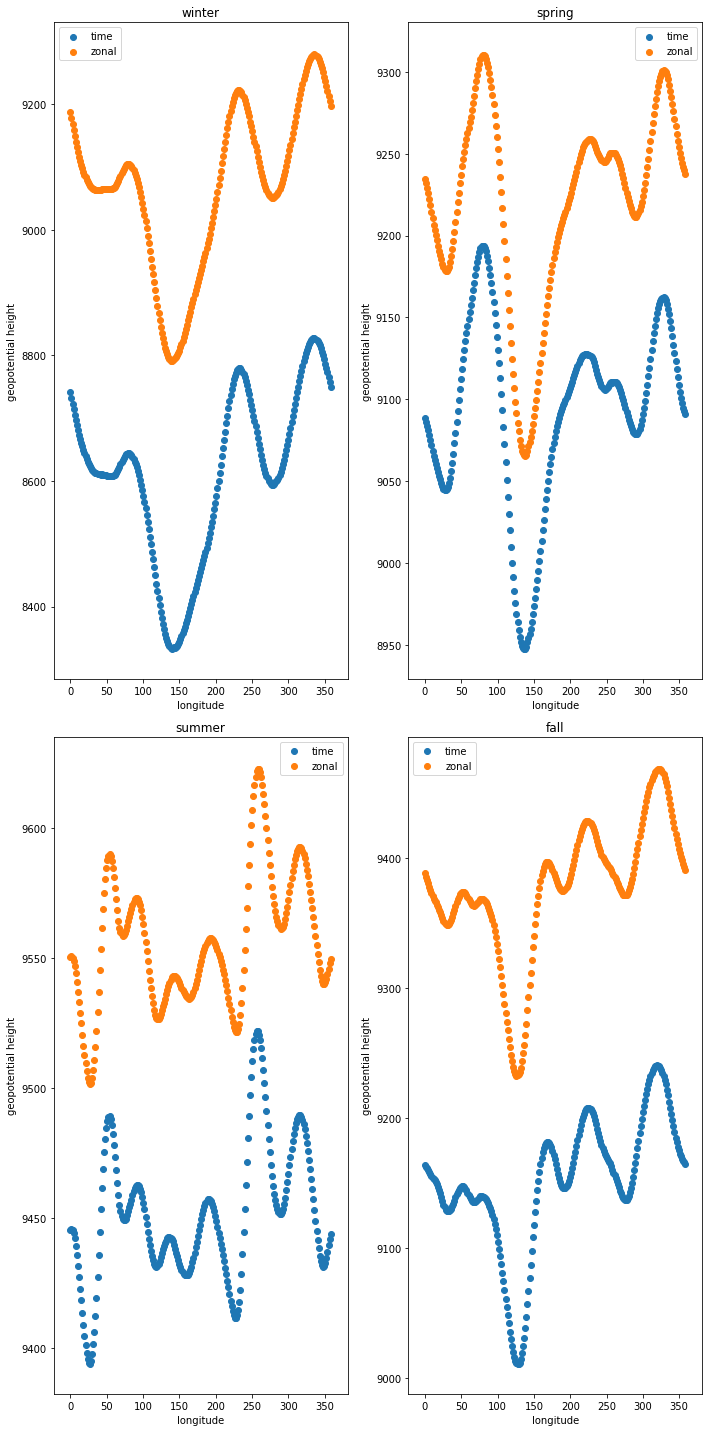

In [13]:
display(Markdown("#### average ifft, time and zonal compared"))

plt.clf()
plt.figure(figsize=(10,20))

for i in range(4):
    plt.subplot(2,2,1 + i)
    plt.scatter(lon_list, np.abs(np.abs(avg_at_lon[i])), label = "time")
    plt.scatter(lon_list, np.abs(zonal_allsea_ifft_list[i]), label = "zonal")
    plt.title(seasons[i])
    plt.legend()
    plt.ylabel("geopotential height")
    plt.xlabel("longitude")

plt.tight_layout()
plt.show()



#### comments: 
these are similar shapes, and have similar magnitudes of change, but this is a result of compensating for windowing with the coherent gain. Below, I will plot these without the coherent gain to show how different they are

In [57]:
#get the iffts with no gain
nogain_time_allsea_ifft_list = [[ifft(sublist / 2) for sublist in time_ffts_list_avg[j]] 
                         for j in range(4)]

In [58]:
#get the mean for each season at each longitude?
avg_at_lon_nogain = [[np.mean(nogain_time_allsea_ifft_list[season][i]) 
               for i in range(240)] for season in range(4)]

#### average ifft, time, zonal, gain compared

<Figure size 432x288 with 0 Axes>

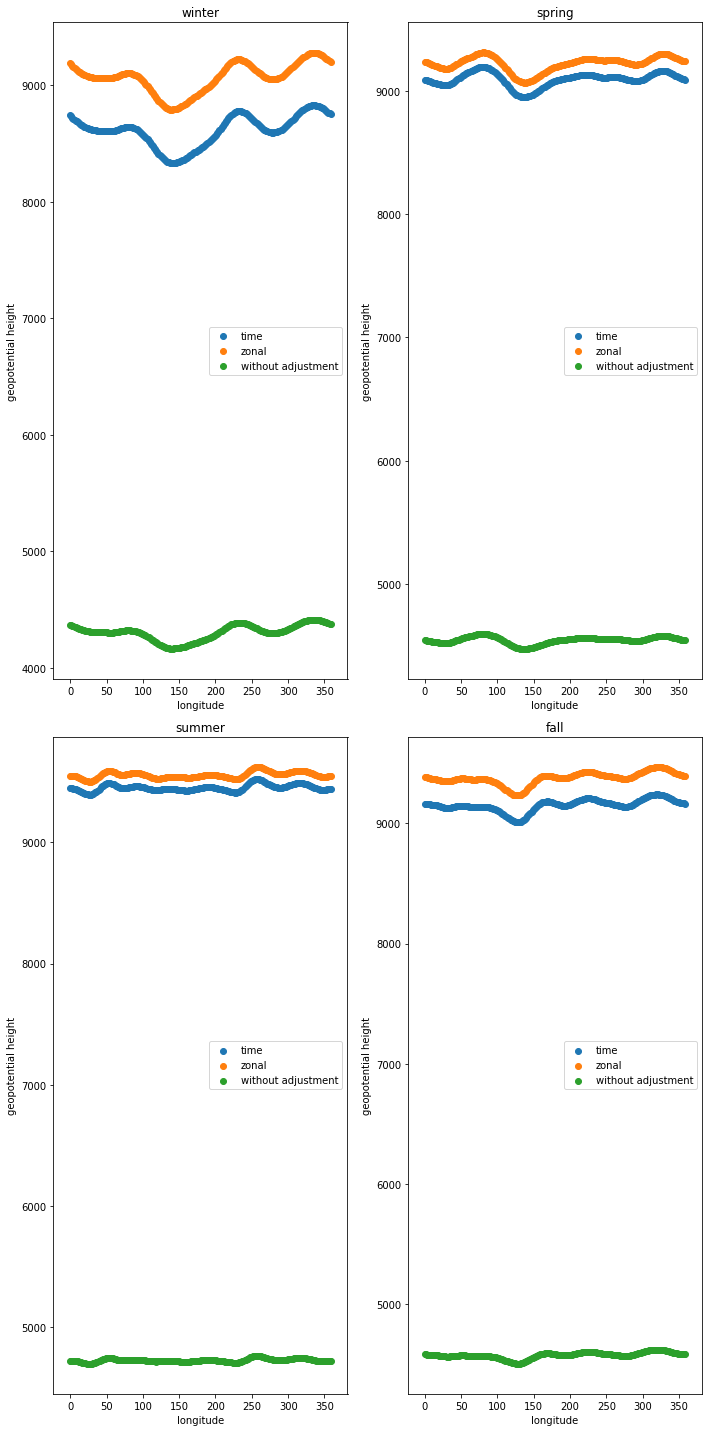

In [63]:
display(Markdown("#### average ifft, time, zonal, gain compared"))

plt.clf()
plt.figure(figsize=(10,20))

for i in range(4):
    plt.subplot(2,2,1 + i)
    plt.scatter(lon_list, np.abs(np.abs(avg_at_lon[i])), label = "time")
    plt.scatter(lon_list, np.abs(zonal_allsea_ifft_list[i]), label = "zonal")
    plt.scatter(lon_list, np.abs(np.abs(avg_at_lon_nogain[i])), label = "without adjustment")
    plt.title(seasons[i])
    plt.legend()
    plt.ylabel("geopotential height")
    plt.xlabel("longitude")

plt.tight_layout()
plt.show()



so the curves are similar as far as can be told on this plot, but is the magnitude the same? is that the only difference?
to see, will add the difference mean of the zonal curve and the without adjustment time curve

In [62]:
#get the differences in means
mean_zone = np.average(zonal_allsea_ifft_list, axis = 0)
mean_nogain = np.average(avg_at_lon_nogain, axis = 0)
difference = mean_zone - mean_nogain

#add back the differences
avg_at_lon_nogain_diff = avg_at_lon_nogain + difference

#### average ifft, time, zonal, gain compared - with added difference

<Figure size 432x288 with 0 Axes>

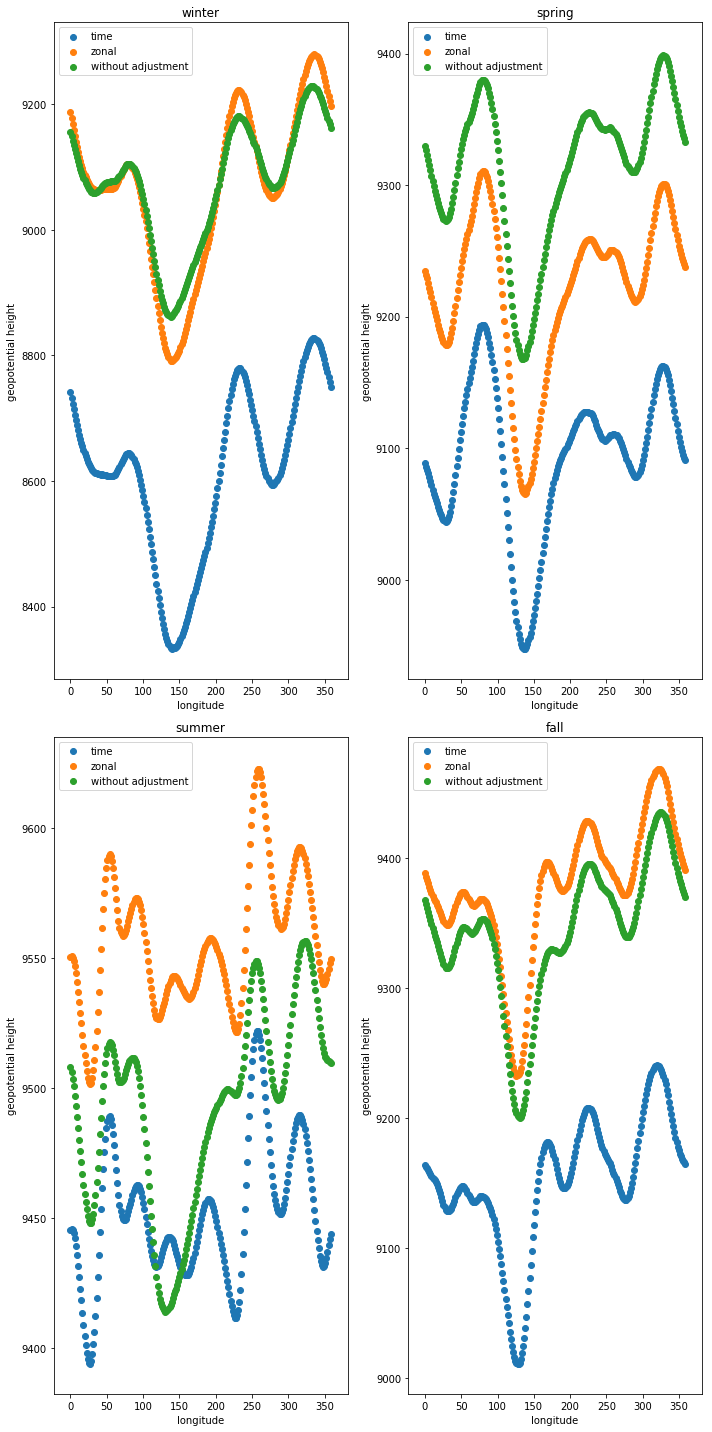

In [64]:
display(Markdown("#### average ifft, time, zonal, gain compared - with added difference"))

plt.clf()
plt.figure(figsize=(10,20))

for i in range(4):
    plt.subplot(2,2,1 + i)
    plt.scatter(lon_list, np.abs(np.abs(avg_at_lon[i])), label = "time")
    plt.scatter(lon_list, np.abs(zonal_allsea_ifft_list[i]), label = "zonal")
    plt.scatter(lon_list, np.abs(np.abs(avg_at_lon_nogain_diff[i])), label = "without adjustment")
    plt.title(seasons[i])
    plt.legend()
    plt.ylabel("geopotential height")
    plt.xlabel("longitude")

plt.tight_layout()
plt.show()



So this looks better - but still not correct - leading me to believe that the dividing coherent gain is the best way to correct for this. 

## look at distributions/departure from geopotential mean in each season

want plot of both departure from mean and from mean, each color is from zonal and time - after that - after that, average the two/or figure something out -- perhaps better to compare with the original first and then apply the correction factor -- would make the most sense to give it the same mean as the zonal average - as there is no windowing there, but maybe not normalize it to the same standard deviation

### get original data for comparative purposes

In [14]:
orig_avg4_df = pd.read_pickle('avg4_df.pickle')
orig_geopot_df = pd.read_pickle('geopot_df.pickle')

### put ifft data into dataframe for transform

#### zonal first

In [15]:
#get flattened list with seasonal averages and zonal averages
flat_season_zonal_ifft_avg = [item for sublist in zonal_allsea_ifft_list for item in sublist]

flat_season_zonal_ifft_avg.extend(ifft(total_zonal_fft_avg))

#make lists to correctly index
season_df_list = []
lon_df_list = []

for season in seasons:
    for longitude in lon_list:
        season_df_list.append(season)
        lon_df_list.append(longitude)

season_tot = ["all" for i in range(240)]

season_df_list.extend(season_tot)
lon_df_list.extend(lon_list)

#make into a dataframe
d = {"season": season_df_list, "lon": lon_df_list, "z": flat_season_zonal_ifft_avg}

zonal_df = pd.DataFrame(d)

#### now time

In [16]:
#get flattened list with seasonal averages
flat_season_time_ifft_avg = [item for sublist in zonal_allsea_ifft_list for item in sublist]

#make lists to correctly index
season_df_list = []
lon_df_list = []
day_index_df = []

for season in seasons:
    for longitude in lon_list:
        season_df_list.append(season)
        lon_df_list.append(longitude)
        
        day_index_df.extend(list(range(len(time_allsea_ifft_list[0][1]))))

#make into a dataframe
d = {"season": season_df_list, "lon": lon_df_list, "z": flat_season_time_ifft_avg}

time_df = pd.DataFrame(d)

#### get seasonal  and section averages so can compare distributions to the original data

In [19]:
#set lists of longitude sections
lon_1 = 'lon >= 50 & lon <= 140'
lon_2 = 'lon <= 50 | lon >= 320'
lon_3 = 'lon >= 230 & lon <= 320'
lon_4 = 'lon >= 140 & lon <= 230'
lon_labels = [lon_1, lon_2, lon_3, lon_4]

## write function to separate zonal stuff into sections - for meaning and comparison purposes
def lon_sort(x):
    #takes a longtude and then returns it ranges number
    
    lon_cond_1 = x >= 50 and x <= 140
    lon_cond_2 = x <= 50 or x >= 320
    lon_cond_3 = x >= 230 and x <= 320
    lon_cond_4 = x >= 140 and x <= 230
    
    conditions = [lon_cond_1, lon_cond_2, lon_cond_3, lon_cond_4]
    
    for i in range(len(conditions)):
        if conditions[i] is True:
            return i

In [20]:
time_df["lon_sec"] = time_df["lon"].apply(lambda x: lon_sort(x))
zonal_df["lon_sec"] = zonal_df["lon"].apply(lambda x: lon_sort(x))

In [26]:
time_df["seasonmean"] = time_df.groupby(by = ["season","lon"])["z"].transform("mean")
time_df["mean_diff"] = time_df["z"] - time_df["seasonmean"] 

time_df["seasonmean"] = time_df.groupby(by = ["season","lon"])["z"].transform("mean")

In [22]:
#get the correct dataframe
day_df = orig_geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
season = "winter"
orig_plot_df = day_df[day_df["season"] == season]
zone_plot_df = zonal_df[zonal_df["season"] == season]
time_plot_df = time_df[time_df["season"] == season]

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:761: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/home/clairev/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/clairev/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2059: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

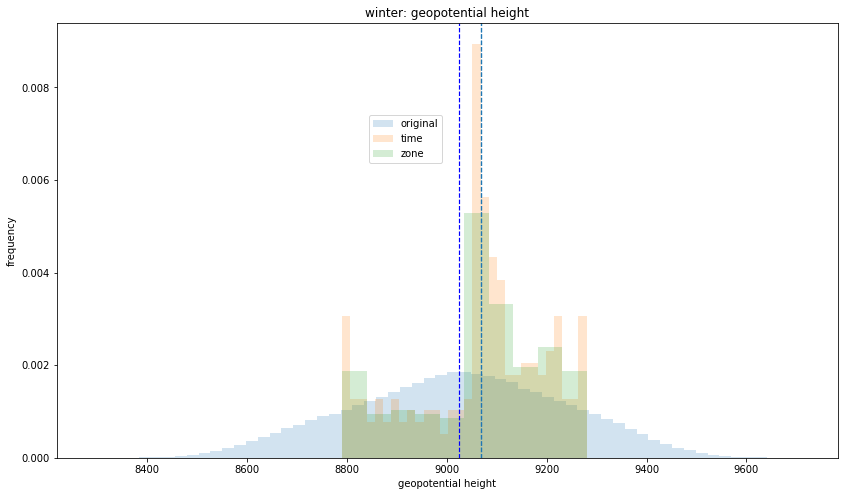

In [25]:
## do sample for winter bc I am lazy and dread things

#plot the histogram for the entire season
plt.clf();
plt.figure(figsize=(14,8))
plt.hist(orig_plot_df['geofrom_climmonth'], bins = 60, alpha = .2, label = "original", density = True)
plt.hist(time_plot_df['z'], bins = 30,alpha = .2, label = "time", density = True)
plt.hist(zone_plot_df['z'], alpha = .2, label = "zone", density = True)
plt.axvline(orig_plot_df['geofrom_climmonth'].mean(), linestyle='dashed', linewidth=1.2, color = "blue")
plt.axvline(zone_plot_df['z'].mean(), linestyle='dashed', linewidth=1.2)
plt.axvline(time_plot_df['z'].mean(), linestyle='dashed', linewidth=1.2)
plt.legend(bbox_to_anchor=[0.5, 0.8],ncol=1)
plt.ylabel('frequency')
plt.xlabel('geopotential height')
plt.title(season + ': geopotential height');
plt.show()

This doesn't look quite right/has no extreme events -- perhaps the seasonal averaging doesn't allow for enough extreme data.